# LAB 2

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn import tree as sklearn_tree
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

In [51]:
# Załadowanie daych
path = 'archive/'
all_files = glob.glob(os.path.join(path, "data-*"))
li = []

for filename in all_files:
    df = pd.read_csv(filename, sep='\t', header=None, names=['Date', 'Time', 'Code', 'Value'])

    df['Patient_ID'] = os.path.basename(filename)
    li.append(df)

full_data = pd.concat(li, axis=0, ignore_index=True)

In [52]:
# Przygotowanie danych
full_data['Timestamp'] = pd.to_datetime(full_data['Date'] + ' ' + full_data['Time'], errors='coerce')

full_data['Value'] = pd.to_numeric(full_data['Value'], errors='coerce')
full_data.dropna(subset=['Timestamp', 'Value'], inplace=True)
full_data.sort_values(by=['Patient_ID', 'Timestamp'], inplace=True)

# Mapowanie i grupowanie kodów
intensity_map = {
    68: 1, 66: 2, 67: 3,  # Posiłki: mały, typowy, duży
    71: 1, 69: 2, 70: 3   # Ćwiczenia: małe, typowe, duże
}
def group_codes(code):
    if code in [33, 34, 35]: return 'Insulin_Dose'
    if code in [48, 57, 58, 59, 60, 61, 62, 63, 64]: return 'Glucose_Level'
    if code in [66, 67, 68]: return 'Meal_Intensity'
    if code in [69, 70, 71]: return 'Exercise'
    if code == 65: return 'Hypoglycemic_Symptoms'
    return 'Other'

full_data['Category'] = full_data['Code'].apply(group_codes)
# full_data['Model_Value'] = full_data.apply(lambda row: intensity_map.get(row['Code'], row['Value']), axis=1)
full_data['Model_Value'] = full_data.apply(lambda row: 1 if row['Code'] == 65 else intensity_map.get(row['Code'], row['Value']), axis=1)
# Wyciągnięcie cech czasowych
full_data['Hour'] = full_data['Timestamp'].dt.hour
full_data['Time_Delta'] = full_data.groupby('Patient_ID')['Timestamp'].transform(lambda x: (x - x.min()).dt.total_seconds())

# Pivotowanie
df_model = full_data.pivot_table(
    index=['Patient_ID', 'Timestamp', 'Hour', 'Time_Delta'],
    columns='Category',
    values='Model_Value',
    aggfunc='mean'
).reset_index()

# Uzupełniamy dane w czasie

cols_to_fill = ['Glucose_Level', 'Insulin_Dose', 'Meal_Intensity', 'Exercise', 'Hypoglycemic_Symptoms', 'Other']
for col in cols_to_fill:
    if col in df_model.columns:
        df_model[col] = df_model.groupby('Patient_ID')[col].ffill().fillna(0)

#print("Finalne kolumny gotowe do modelu:", df_model.columns.tolist())
# Sprawdzenie hypoglycemic symptoms
# print(f"Suma objawów: {df_model['Hypoglycemic_Symptoms'].sum()}")
# print(full_data[full_data['Code'] == 65])
# print("Liczba odnotowanych objawów hipoglikemii:", df_model['Hypoglycemic_Symptoms'].sum())
# print(df_model.describe())
# df_model

In [53]:
# 3. Dodajemy Lagi i Średnie
df_model['Insulin_Lag1'] = df_model.groupby('Patient_ID')['Insulin_Dose'].shift(1).fillna(0)
df_model['Meal_Lag1'] = df_model.groupby('Patient_ID')['Meal_Intensity'].shift(1).fillna(0)
df_model['Glucose_Rolling_Mean'] = df_model.groupby('Patient_ID')['Glucose_Level'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# 4. Dodajemy fazy dnia i One-Hot Encoding
def get_day_phase(hour):
    if 6 <= hour < 10: return 'Morning'
    elif 10 <= hour < 18: return 'Day'
    elif 18 <= hour < 23: return 'Evening'
    else: return 'Night'

df_model['Day_Phase'] = df_model['Hour'].apply(get_day_phase)
df_model = pd.get_dummies(df_model, columns=['Day_Phase'], prefix='Phase')

df_model.drop(columns=['Timestamp', 'Patient_ID', 'Other'], errors='ignore', inplace=True)

Trenowanie klasyfikatorów

In [54]:
# Przygotowanie danych
X = df_model.drop(columns=['Glucose_Level'])
y = df_model['Glucose_Level']
y_class = (df_model['Glucose_Level'] > 180).astype(int)
#print(y_class.value_counts())

# 1. Podział danych
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# 2. Skalowanie
scaler_svm = StandardScaler()
X_train_scaled = scaler_svm.fit_transform(X_train)
X_test_scaled = scaler_svm.transform(X_test)

# 3. Budowa i trenowanie modeli
models = {
    "Pojedyncze Drzewo": DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced'),
    "Bagging": BaggingClassifier(n_estimators=50, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42)
}

# Pętla trenująca i wyświetlająca wyniki
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    f1 = f1_score(y_test, y_pred)
    results[name] = f1

    print(f"\n=== {name} ===")
    print(f"F1-score dla klasy 1: {f1:.4f}")
    print(classification_report(y_test, y_pred))




=== Pojedyncze Drzewo ===
F1-score dla klasy 1: 0.7188
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      2297
           1       0.66      0.78      0.72      1367

    accuracy                           0.77      3664
   macro avg       0.76      0.77      0.76      3664
weighted avg       0.78      0.77      0.77      3664


=== Bagging ===
F1-score dla klasy 1: 0.7443
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      2297
           1       0.76      0.73      0.74      1367

    accuracy                           0.81      3664
   macro avg       0.80      0.80      0.80      3664
weighted avg       0.81      0.81      0.81      3664


=== Random Forest ===
F1-score dla klasy 1: 0.7610
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2297
           1       0.78      0.75      0.76      1367

    accuracy                

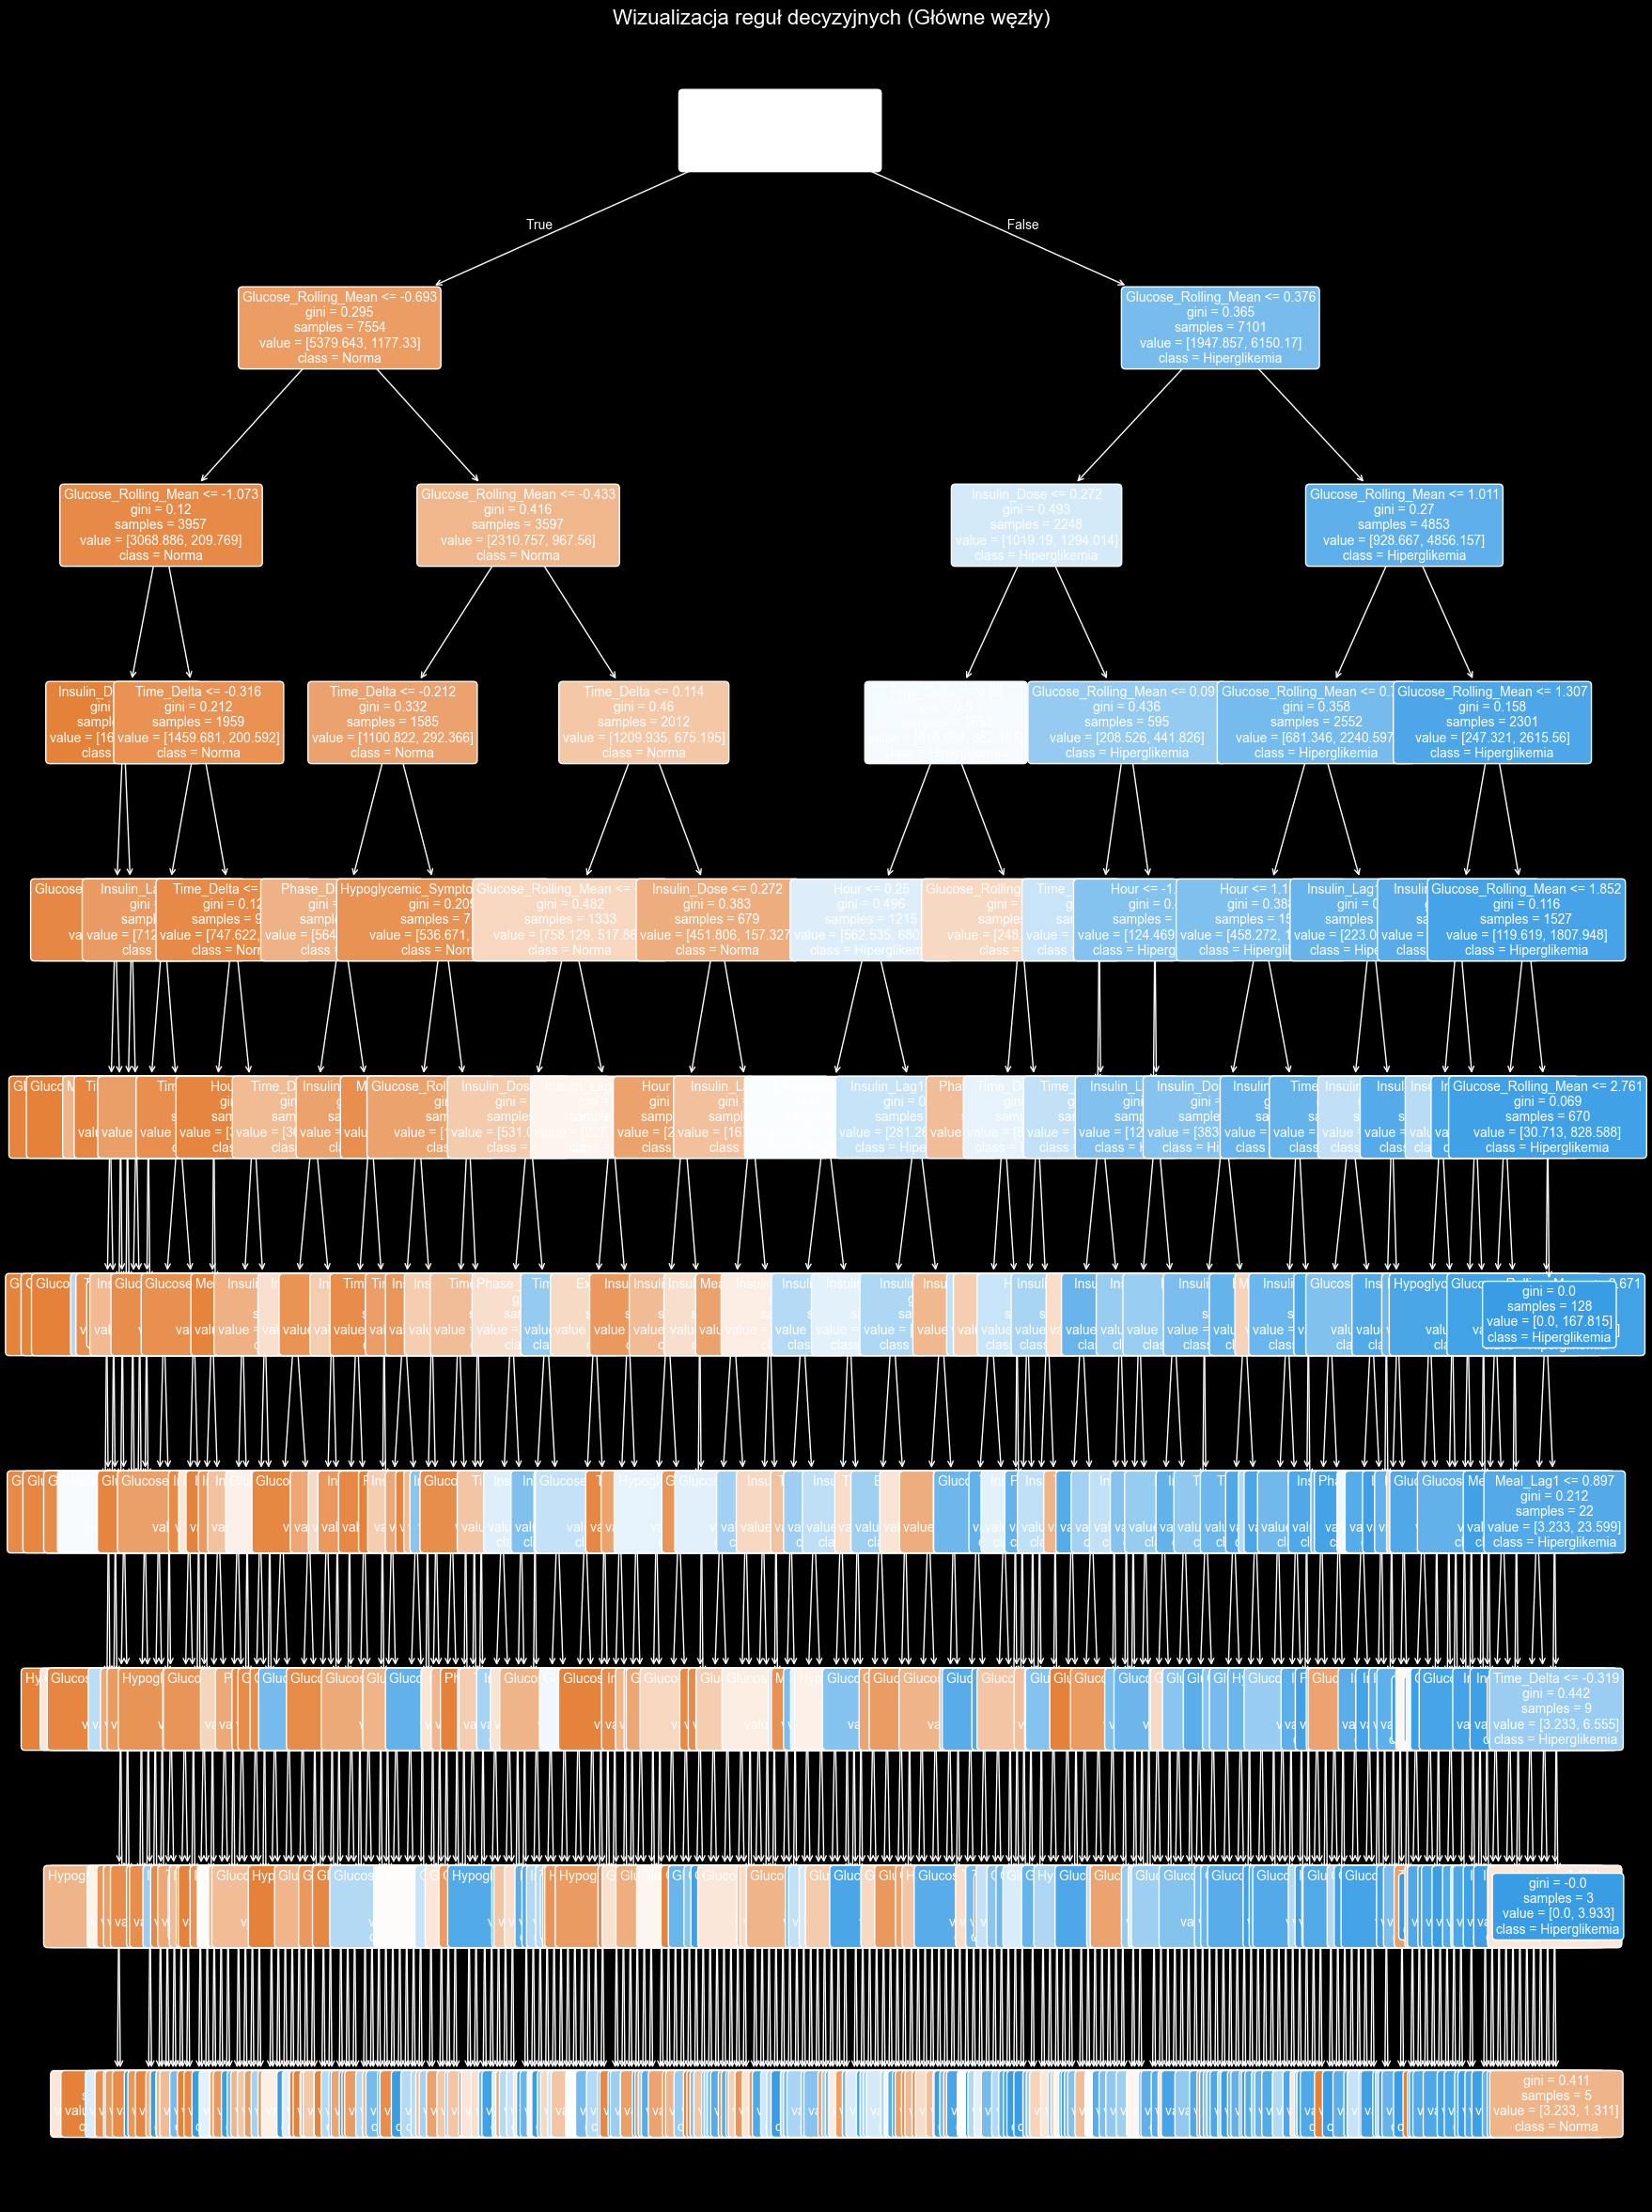

In [67]:
single_tree = models["Pojedyncze Drzewo"]

# 2. Rysujemy drzewo
plt.figure(figsize=(20, 30))
plot_tree(
    single_tree,
    feature_names=X.columns.tolist(),
    class_names=['Norma', 'Hiperglikemia'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Wizualizacja reguł decyzyjnych (Główne węzły)", fontsize=16)
plt.show()

Bagging (Bootstrap Aggregating) — podejście zgodne z dostarczonym przykładem


In [56]:
# 2) Model bazowy: pojedyncze drzewo
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_scaled, y_train)
y_pred_tree = tree.predict(X_test_scaled)
acc_tree = accuracy_score(y_test, y_pred_tree)

bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=200,        # liczba estymatorów (więcej -> niższa wariancja, kosztem czasu)
    max_samples=0.8,         # rozmiar bootstrapowej próbki względem zbioru treningowego
    bootstrap=True,          # włączone próbkowanie ze zwracaniem
    n_jobs=-1,               # równoległe trenowanie
    random_state=42,
    oob_score=True           # out-of-bag jako estymacja jakości bez walidacji
)

bag_model.fit(X_train_scaled, y_train)
y_pred_bag = bag_model.predict(X_test_scaled)
acc_bag = accuracy_score(y_test, y_pred_bag)
print(f"OOB score (estymacja wewnętrzna): {bag_model.oob_score_:.3f}")
print(f"Dokładność (pojedyncze drzewo): {acc_tree:.3f}")
print(f"Dokładność (Bagging 200× drzewo): {acc_bag:.3f}")
print("\nRaport klasyfikacji — Bagging:")
print(classification_report(y_test, y_pred_bag))

# Dodatkowo: wynik OOB (zbliżony do walidacyjnego)
print(f"OOB score (Bagging): {getattr(bag_model, 'oob_score_', None)}")


# Wskazówki dot. strojenia:
# - n_estimators: zwykle 50–300; więcej stabilizuje wynik kosztem czasu.
# - max_samples: 0.5–1.0; mniejsze wartości zwiększają zróżnicowanie bazowych modeli.
# - max_features: można ograniczyć liczbę cech dla jeszcze większej dywersyfikacji.
# - estimator: zamiast drzewa można użyć np. KNN, SVM (uwaga na czas).

OOB score (estymacja wewnętrzna): 0.808
Dokładność (pojedyncze drzewo): 0.748
Dokładność (Bagging 200× drzewo): 0.809

Raport klasyfikacji — Bagging:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      2297
           1       0.75      0.73      0.74      1367

    accuracy                           0.81      3664
   macro avg       0.80      0.79      0.80      3664
weighted avg       0.81      0.81      0.81      3664

OOB score (Bagging): 0.8077106789491642


Wizualizacja pojedynczego drzewa z komitetu bagging

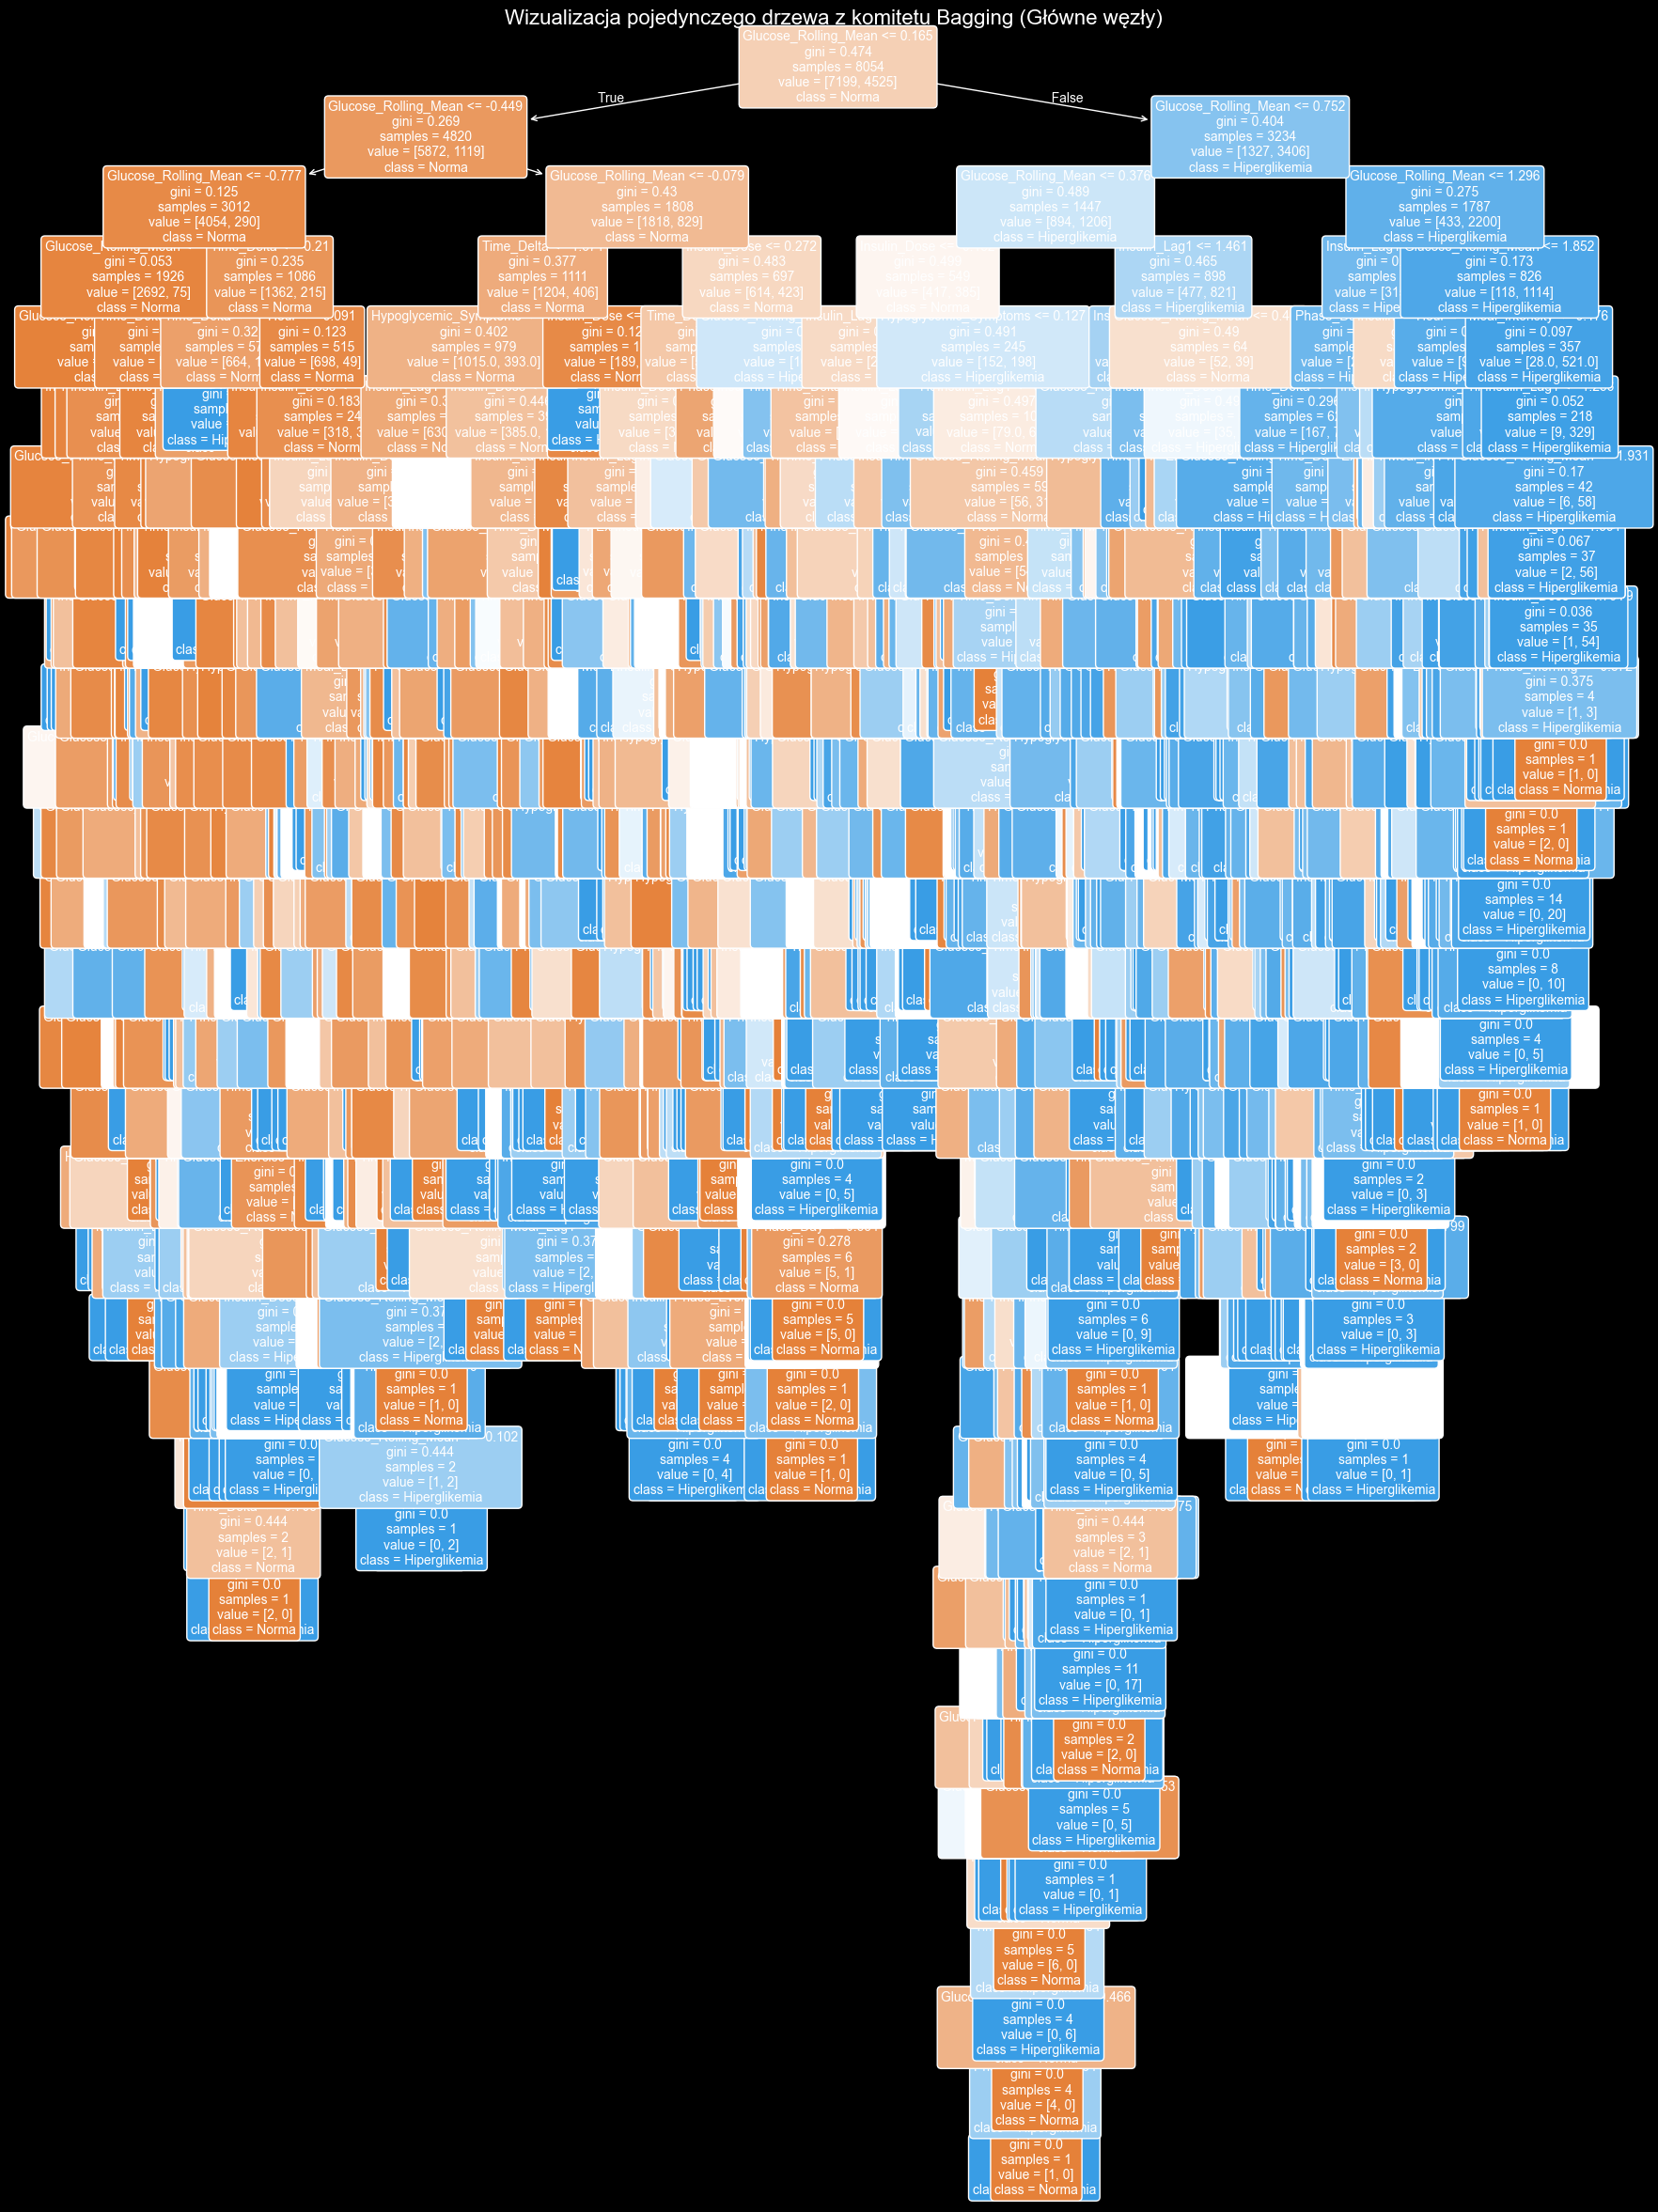

In [64]:
# Wybierz jedno z drzew z komitetu Bagging
estimator = bag_model.estimators_[0]

# 2. Wizualizacja
plt.figure(figsize=(20,30))
sklearn_tree.plot_tree(
    estimator,
    filled=True,
    feature_names=X.columns.tolist(),
    class_names=["Norma", "Hiperglikemia"],
    rounded=True,
    fontsize=10,
#    max_depth=5
)
plt.title("Wizualizacja pojedynczego drzewa z komitetu Bagging (Główne węzły)", fontsize=16)
plt.show()

Ważność cech

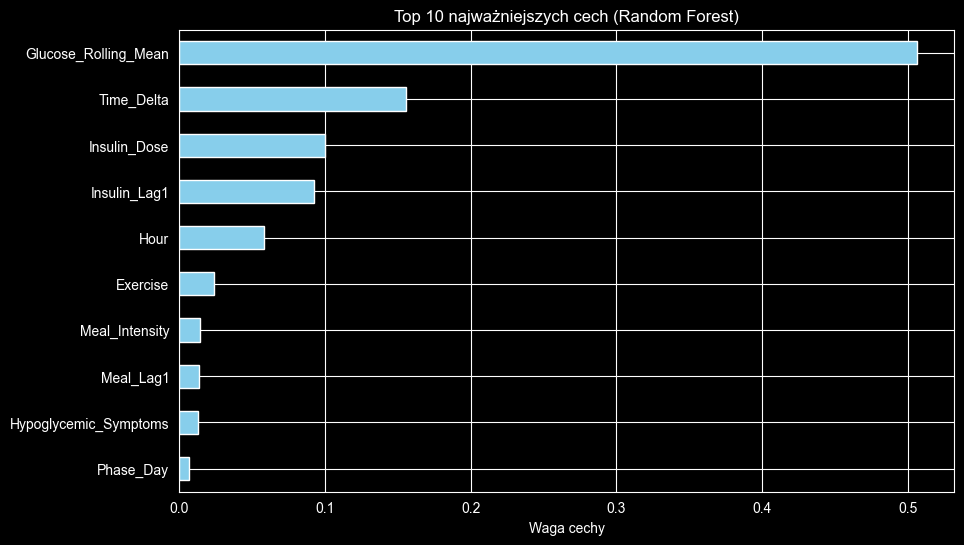

In [58]:
# Pobieramy ważność cech z Random Forest
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
feature_names = X.columns

# Tworzymy wykres
feature_importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feature_importance_df.tail(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 najważniejszych cech (Random Forest)')
plt.xlabel('Waga cechy')
plt.show()

Porównanie

In [59]:
metrics_summary = []
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    metrics_summary.append({
        'Klasyfikator': name,
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1-score ': round(f1, 3)
    })

results_df = pd.DataFrame(metrics_summary)
results_df.set_index('Klasyfikator', inplace=True)

print("Porównanie Klasyfikatorów (Macro Average):")
print(results_df)

Porównanie Klasyfikatorów (Macro Average):
                   Precision  Recall  F1-score 
Klasyfikator                                   
Pojedyncze Drzewo      0.760   0.774      0.763
Bagging                0.801   0.796      0.798
Random Forest          0.815   0.809      0.812
AdaBoost               0.778   0.788      0.781


In [60]:
metrics_class_1 = []
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
    metrics_class_1.append({
        'Klasyfikator': name,
        'Precision': round(precision[1], 3),
        'Recall': round(recall[1], 3),
        'F1-score': round(f1[1], 3)
    })

results_df_1 = pd.DataFrame(metrics_class_1)
results_df_1.set_index('Klasyfikator', inplace=True)

print("Porównanie Klasyfikatorów dla klasy 1 (Hiperglikemia):")
print(results_df_1)

Porównanie Klasyfikatorów dla klasy 1 (Hiperglikemia):
                   Precision  Recall  F1-score
Klasyfikator                                  
Pojedyncze Drzewo      0.664   0.783     0.719
Bagging                0.760   0.729     0.744
Random Forest          0.777   0.745     0.761
AdaBoost               0.698   0.776     0.735


Wizualiacja

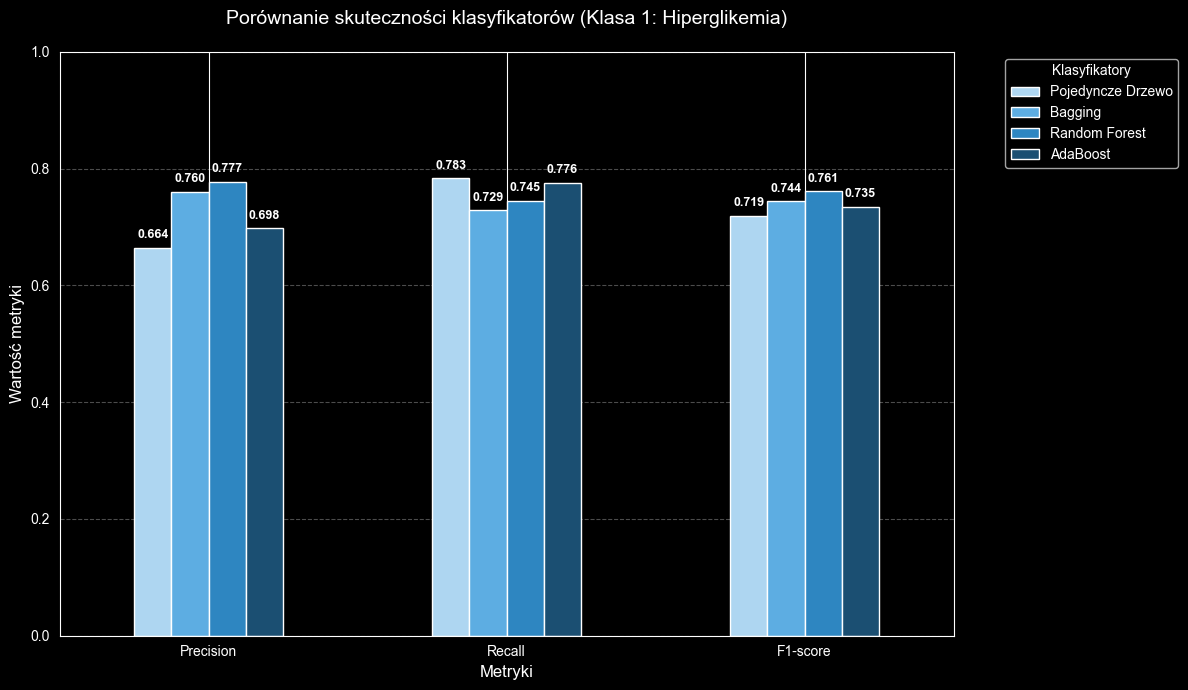

In [61]:
df_to_plot = results_df_1.T

ax = df_to_plot.plot(kind='bar', figsize=(12, 7), rot=0,
                     color=['#AED6F1', '#5DADE2', '#2E86C1', '#1B4F72'])

plt.title('Porównanie skuteczności klasyfikatorów (Klasa 1: Hiperglikemia)', fontsize=14, pad=20)
plt.ylabel('Wartość metryki', fontsize=12)
plt.xlabel('Metryki', fontsize=12)
plt.ylim(0, 1.0)
plt.legend(title="Klasyfikatory", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()